In [ ]:
from Models import ML_Models

In [ ]:
import yfinance as yf
import pandas as pd
import inspect
import datetime as dt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
start_date = "2012-01-01"
end_date = dt.date.today()
main_col = "Adj Close"
interval = "1d"
stocks_list = ["EQNR.OL", "DNB.OL", "TEL.OL", "NHY.OL"]#, "AKRBP.OL", "YAR.OL", "MOWI.OL", "CL=F", "OSEBX.OL"]
indicators = ["MA5", "MA20", "MA50", "MA200"]#, "MIN", "MAX", "LOG_RET", "MOM", "VOLA", "DIFF"]
models = ["Linear", "DTR", "MLP"]
metric_names = ["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error", "neg_mean_absolute_percentage_error"]
pretty_metric_names = {
                "r2":"R^2 Error: ", 
                "neg_mean_absolute_error":"Mean Absolute Error: ", 
                "neg_root_mean_squared_error":"Root Mean Squared Error: ", 
                "neg_mean_absolute_percentage_error":"Mean Absolute Percentage Error: "
            }

In [ ]:
exam_models = ML_Models()

# Collecting data from Yahoo Finance

In [ ]:
stock_data = {}
for ticker in stocks_list:
    print(f"Downloading {ticker} data")
    # fetch stock data from yahoo finance
    raw_data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    stock_data[ticker] = raw_data

# Save fetched data to csv
#for ticker in stocks_list:
#    stock_data[ticker].to_csv("Saved_Data/rawdata_"+ticker+".csv")

# Preproccesing the data

In [ ]:
def add_indicator_columns(data, indicators):
        # Creating label and shifting the selected main_feature value by 1.
        label_name = "Label"
        label_name = label_name
        data[label_name] = data[main_col].shift(periods=1)

        # Checking which of the different indicators that should be added as a column (based on input from indicators list).
        if "MA5" in indicators:
            data["MA5"] = data[label_name].rolling(5).mean()
        if "MA20" in indicators:
            data["MA20"] = data[label_name].rolling(20).mean()
        if "MA50" in indicators:
            data["MA50"] = data[label_name].rolling(50).mean()
        if "MA200" in indicators:
            data["MA200"] = data[label_name].rolling(200).mean()
        if "MIN" in indicators:
            data["MIN"] = data[label_name].rolling(20).min()
        if "MAX" in indicators:
            data["MAX"] = data[label_name].rolling(20).max()
        log_ret = np.log(data[label_name] / data[label_name].shift(1))
        if "LOG_RET" in indicators:
            data["LOG_RET"] = log_ret
        if "MOM" in indicators:
            data["MOM"] = log_ret.rolling(20).mean()
        if "VOLA" in indicators:
            data["VOLA"] = log_ret.rolling(20).std()
        if "DIFF" in indicators:
            data["DIFF"] = data[label_name] - data[label_name].shift(1)

        # remove empty vals.
        data.dropna(axis=0, inplace=True)

In [ ]:
def create_X_y_arrays(data, label_name):
        # array that contains the indicators data.
        X = data.loc[:, indicators].to_numpy()
        # array with the target data (based on main_feature).
        y = data[label_name].to_numpy()
        return X, y

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def create_X_y_train_test_split(X, y, current_stock):
        data = stock_data[current_stock]

        for train_index, test_index in tscv.split(data):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        return X_train, X_test, y_train, y_test

In [ ]:
# Performing the preprocessing
for ticker, data in stock_data.items():
    add_indicator_columns(data=data, indicators=indicators)

# Training models

In [ ]:
# Helper function that choose model from models class
def pick_model(model):
    if model == "Linear":
        return exam_models.model_Linear()
    elif model == "DTR":
        return exam_models.model_DTR()
    elif model == "MLP":
        return exam_models.model_MLP()

In [ ]:
cv_results = {}
trained_models = {}

def train_models(input_models):
        for ticker, data in stock_data.items():

            X, y = create_X_y_arrays(data=data, label_name="Label")

            X_train, X_test, y_train, y_test = create_X_y_train_test_split(X=X, y=y, current_stock=ticker)

            # Evaluating and training selected models.
            for model_i in input_models:
                model = pick_model(model=model_i)
                metric_dict = {}
                for metric_name in metric_names:
                    metric_dict[metric_name] = metric_name
                    # using method from sci-kit lib to cross-validate
                    cross_val_results = cross_validate(
                        model,
                        X,
                        y,
                        cv=tscv,
                        scoring=metric_dict,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=0  
                    )
                    model.fit(X_train, y_train)
                cv_results[ticker+"_model_"+model_i] = cross_val_results 
                trained_models["trained_model_"+model_i+"_"+ticker] = model

        return cv_results

In [ ]:
cv_stocks_models = train_models(input_models=models)

In [ ]:
display(trained_models)

# Predicting values based on trained models &
# Evaluating them based on error metrics 

In [34]:
stock_predictions = {}
y_pred = 0
def predict_trained_models(input_models):
    for ticker, data in stock_data.items():

        # Creating X and y arrays for train and test sets.
        X, y = create_X_y_arrays(data=data, label_name= "Label")

        X_train, X_test, y_train, y_test = create_X_y_train_test_split(X=X, y=y, current_stock=ticker)

        last_train_index, last_test_index = None, None

        for train_index, test_index in tscv.split(data):
            last_train_index, last_test_index = train_index, test_index

        prediction = data.loc[data.index[last_test_index], [main_col]].copy(deep=True)
        stock_predictions[ticker] = prediction

        for model_i in input_models:
            model = trained_models["trained_model_"+model_i+"_"+ticker]
            y_pred = model.predict(X_test)
            prediction.loc[:, model_i+" Prediction"] = y_pred

    return stock_predictions

In [35]:
predicted_stock_data = predict_and_evaluate_trained_models(input_models=models)

In [ ]:
for ticker in stocks_list:
    print(ticker)
    display(predicted_stock_data[ticker])

In [ ]:
def print_metrics(save_data_to_df=True):
    for ticker, data in stock_data.items():
        print("\n--------", "Stock:", ticker, "--------")

        # prepare dataframe if requested
        metrics_df_container = {}
        if save_data_to_df:
            metrics_df = pd.DataFrame(index=list(pretty_metric_names.values()))
            metrics_df_container[ticker] = metrics_df
            current_metrics_df = metrics_df

        for model_name in models:        
            cv = cv_results[ticker+"_model_"+model_name]

            print("---", "Model:", model_name, "---")
            print("--", "Training Scores:", "--")
            split1_errors_string = f"Score for first data split -\n"
            split3_errors_string = f"Score for third data split -\n"
            split5_errors_string = f"Score for last data split -\n"

            for error_metric_name in metric_names:
                # some metrics are saved as negative, so change sign
                if error_metric_name.startswith("neg"):
                    try:
                        error_metric_value = -cv["train"+"_"+error_metric_name]
                    # string being passed that can't be negative
                    except:
                        error_metric_value = cv["train"+"_"+error_metric_name]
                else:
                    error_metric_value = cv["train"+"_"+error_metric_name]

                if save_data_to_df:
                    # pass string, used to indicate missing metrics
                    if isinstance(error_metric_value, str):
                        current_metrics_df.loc[pretty_metric_names[error_metric_name], model_name+" Model "+"Train"] = error_metric_value
                    # otherwise mean of all splits
                    else:
                        current_metrics_df.loc[pretty_metric_names[error_metric_name], model_name+" Model "+"Train"] = np.mean(error_metric_value)
        
                if isinstance(error_metric_value, str):
                    split1_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split1_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[0]:.3f}\n"

                if isinstance(error_metric_value, str):
                    split3_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split3_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[2]:.3f}\n"
    
                if isinstance(error_metric_value, str):
                    split5_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split5_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[-1]:.3f}\n"

            # print the two strings
            print(split1_errors_string+"\n"+split3_errors_string+"\n"+split5_errors_string)
            
            # print a newline to separate from other prints
            print("", end="\n")

            print("--", "Testing Scores:", "--")
            split1_errors_string = f"Score for first data split -\n"
            split3_errors_string = f"Score for third data split -\n"
            split5_errors_string = f"- Score for last data split -\n"

            for error_metric_name in metric_names:
                # some metrics are saved as negative, so change sign
                if error_metric_name.startswith("neg"):
                    try:
                        error_metric_value = -cv["test"+"_"+error_metric_name]
                    # string being passed that can't be negative
                    except:
                        error_metric_value = cv["test"+"_"+error_metric_name]
                else:
                    error_metric_value = cv["test"+"_"+error_metric_name]

                if save_data_to_df:
                    # pass string, used to indicate missing metrics
                    if isinstance(error_metric_value, str):
                        current_metrics_df.loc[pretty_metric_names[error_metric_name], model_name+" Model "+"Test"] = error_metric_value
                    # otherwise mean of all splits
                    else:
                        current_metrics_df.loc[pretty_metric_names[error_metric_name], model_name+" Model "+"Test"] = np.mean(error_metric_value)
        
                if isinstance(error_metric_value, str):
                    split1_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split1_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[0]:.3f}\n"

                if isinstance(error_metric_value, str):
                    split3_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split3_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[2]:.3f}\n"

                if isinstance(error_metric_value, str):
                    split5_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value}\n"
                else:
                    split5_errors_string += f"{pretty_metric_names[error_metric_name]} {error_metric_value[-1]:.3f}\n"

            # print the two strings
            print(split1_errors_string+"\n"+split3_errors_string+"\n"+split5_errors_string)

            # print a newline to separate from other prints
            print("", end="\n")

    if save_data_to_df:
        return metrics_df
    else:
        return None

In [ ]:
metrics_output = print_metrics(save_data_to_df=False)

# Plots for insights about the data

In [ ]:
import matplotlib.pyplot as plt

# PLOT FOR SHOWING DIFFERENT DATA SPLITS FOR THE DIFFERENT STOCKS
for ticker in stocks_list:
    figure, axs = plt.subplots(5, figsize=(16,20))
    figure.set_tight_layout(True)

    data = stock_data[ticker]

    tscv = TimeSeriesSplit(n_splits=5)

    current_splits = tscv.split(data)
        
    i = 0
    for axes, (train_index, test_index) in zip(axs, current_splits):
        axes.plot(data.index[train_index], data.loc[data.index[train_index], main_col], label=f"Training data {i+1}", color="blue")
        axes.plot(data.index[test_index], data.loc[data.index[test_index], main_col], label=f"Test data {i+1}", color="red")

        axes.set_xlim(data.index[0], data.index[-1])

        axes.set_title(f"Train / test split {i+1} for {ticker}")
        axes.set_xlabel("Date")
        axes.set_ylabel(f"{main_col}")
        axes.legend()

        i = i+1

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

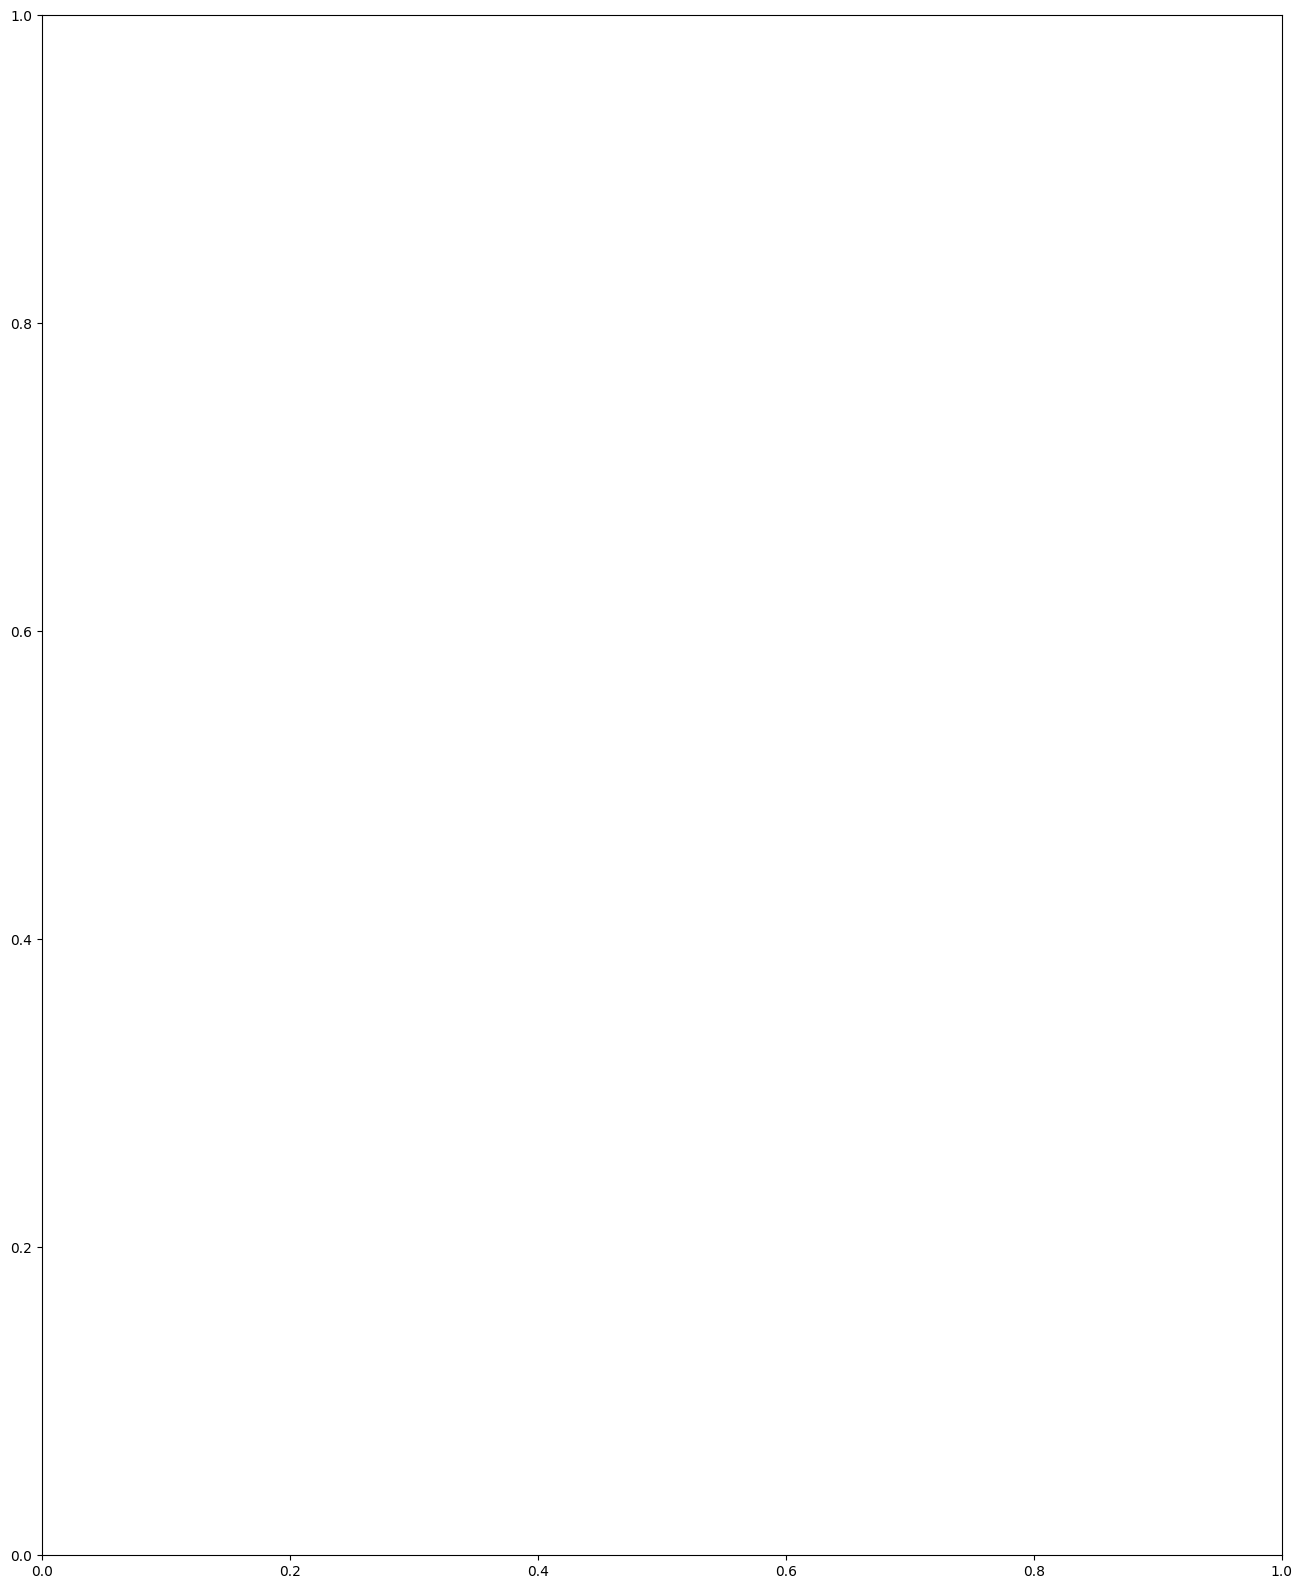

In [51]:
# PLOT FOR COMPARING ACTUAL TO PREDICTED VALUES
for ticker, data in stock_data.items():
    figure, axs = plt.subplots(figsize=(16,20))

    X, y = create_X_y_arrays(data=data, label_name="Label")
    X_train, X_test, y_train, y_test = create_X_y_train_test_split(X=X, y=y, current_stock=ticker)

    plt.plot(data.index[X_test.index], y_test, color='blue', label='Actual')
    plt.plot(data.index[X_test.index], stock_predictions[ticker], color='red', label='Predicted')
    plt.title(f'Actual vs Predicted, {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    plt.show()